# About Dataset
Animal faces dataset from Kaggle: [https://www.kaggle.com/datasets/andrewmvd/animal-faces](https://www.kaggle.com/datasets/andrewmvd/animal-faces)

# Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
%matplotlib inline

# Helper Function: Create DataFrame
- Takes a path to a folder (train/val) containing classes (sub-folders)
- Returns a DataFrame with 2 columns: filename, class

In [2]:
def create_dataframe(data_path):
    df = []
    for c in os.listdir(data_path):
        class_folder = os.path.join(data_path, c)
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            if f_path.endswith('jpg'):
                df.append([f_path, c])
    return pd.DataFrame(df, columns=('filename', 'class'))

# Creating DataFrames

In [3]:
# constants
IMG_DIM = 224
DATA_PATH = 'data/'
CLASSES = sorted(['cat', 'dog', 'wild'])
print(CLASSES)

['cat', 'dog', 'wild']


In [4]:
# creating dataframes
df = create_dataframe(os.path.join(DATA_PATH, 'train'))
df_test = create_dataframe(os.path.join(DATA_PATH, 'val'))

# Splitting Data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_val = train_test_split(df, test_size=0.30, random_state=0)

In [8]:
df_train

,filename,class
13636,data/train\wild\pixabay_wild_000163.jpg,wild
12639,data/train\wild\flickr_wild_003043.jpg,wild
3652,data/train\cat\pixabay_cat_003191.jpg,cat
7294,data/train\dog\pixabay_dog_001210.jpg,dog
1278,data/train\cat\pixabay_cat_000606.jpg,cat
...,...,...
13123,data/train\wild\flickr_wild_003588.jpg,wild
3264,data/train\cat\pixabay_cat_002767.jpg,cat
9845,data/train\dog\pixabay_dog_004009.jpg,dog
10799,data/train\wild\flickr_wild_001007.jpg,wild


# Data generators (reading data from disk)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_gen = ImageDataGenerator().flow_from_dataframe(
    df_train,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
)

val_gen = ImageDataGenerator().flow_from_dataframe(
    df_val,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
    shuffle=False,
)

test_gen = ImageDataGenerator().flow_from_dataframe(
    df_test,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
    shuffle=False,
)

Found 10241 validated image filenames belonging to 3 classes.
Found 4389 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [11]:
train_gen.class_indices

{'cat': 0, 'dog': 1, 'wild': 2}

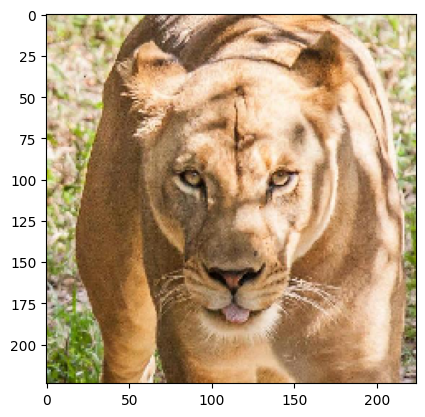

In [12]:
img = train_gen[0][0][0]
plt.imshow(img/255.0)
plt.show()

# Models

In [14]:
 import tensorflow as tf
 print(tf.config.list_physical_devices('GPU'))
 print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


### 1. Custom CNN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAvgPool2D, Dense, Flatten

model = Sequential()
model.add(Conv2D(16, 7, activation='relu', input_shape=(IMG_DIM, IMG_DIM, 3)))
model.add(Conv2D(16, 7, activation='relu'))
model.add(Conv2D(16, 7, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 5, activation='relu'))
model.add(Conv2D(32, 5, activation='relu'))
model.add(Conv2D(32, 5, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu', name='last_conv'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

MODEL_PATH = 'saved-models/cnn'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 212, 212, 16)      12560     
                                                                 
 conv2d_2 (Conv2D)           (None, 206, 206, 16)      12560     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 103, 103, 16)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 99, 99, 32)        12832     
                                                                 
 conv2d_4 (Conv2D)           (None, 95, 95, 32)        25632     
                                                        

### 2. MobileNet

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import GlobalAvgPool2D, Dense

In [24]:
pretrained = MobileNetV2(
    input_shape=(IMG_DIM, IMG_DIM, 3),
    include_top=False
)
pretrained.trainable = False

model = Sequential()
model.add(pretrained)
model.add(GlobalAvgPool2D())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

MODEL_PATH = 'saved-models/mobilenet'

9406464/9406464 [==============================] - 195s 21us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


### 3. ResNet

In [15]:
from tensorflow.keras.applications.resnet import ResNet152

In [62]:
pretrained = ResNet152(
    input_shape=(IMG_DIM, IMG_DIM, 3),
    include_top=False
)
pretrained.trainable = False

inputs = pretrained.input

x = tf.keras.layers.GlobalAveragePooling2D()(pretrained.output)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

MODEL_PATH = 'saved-models/resnet'

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [63]:
pretrained.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

# Training

In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(MODEL_PATH,
                            save_weights_only=True,
                            save_best_only=True,
                            verbose=1)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=6,
    callbacks=[checkpoint],
)

Epoch 1/6
321/321 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9779
Epoch 1: val_loss improved from inf to 0.01931, saving model to saved-models\resnet
321/321 [==============================] - 245s 725ms/step - loss: 0.0657 - accuracy: 0.9779 - val_loss: 0.0193 - val_accuracy: 0.9945
Epoch 2/6
  3/321 [..............................] - ETA: 7:30 - loss: 0.0169 - accuracy: 1.0000

KeyboardInterrupt: 

# Loading best weights and Testing

In [66]:
print(MODEL_PATH)
model.load_weights(MODEL_PATH)
model.evaluate(test_gen)

saved-models/resnet
 9/47 [====>.........................] - ETA: 56s - loss: 0.0093 - accuracy: 0.9965

KeyboardInterrupt: 

# Saliency maps

In [73]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_3_conv", pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the chosen layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the chosen layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the chosen layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [78]:
heatmap = make_gradcam_heatmap(np.expand_dims(test_gen[0][0][0],0),model)

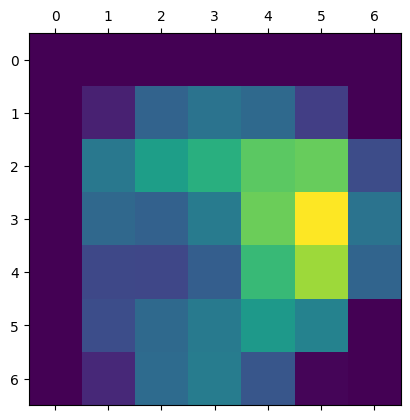

In [79]:
## visulization of heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match the size of the input image
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to 3-channel heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Combine heatmap with the original image
    overlay_image = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)

    return overlay_image

# Load the original image (assuming you have it)
original_image = cv2.imread("original_image.jpg")

# Generate the heatmap using Grad-CAM
heatmap = make_gradcam_heatmap(np.expand_dims(test_gen[0][0][0],0), model)

# Overlay the heatmap on the original image
overlay_image = overlay_heatmap(original_image, heatmap)

# Display the overlay image
cv2.imshow("Grad-CAM", overlay_image)
cv2.waitKey(0)
cv2.destroyAllWindows()